## Capstone 3. Clustering countries based on different socioeconomic factors ##

The objective of this project is to categorise the countries using socio-economic and health factors that determine the overall development of the country.

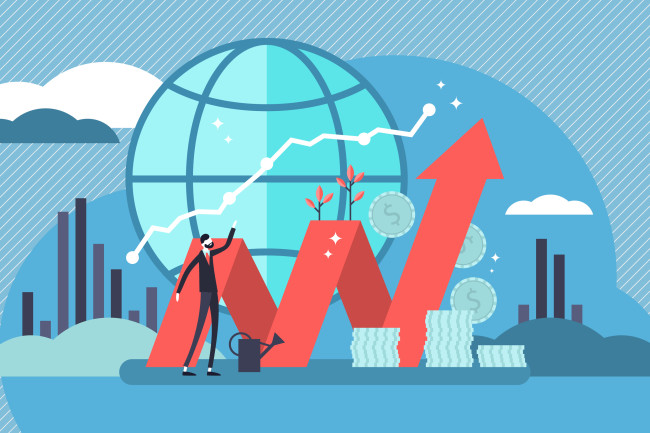

1. The first step is to set up the enviroment and read the data file.

In [1]:
# Setting up the enviroment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dabl
import warnings 
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform



%matplotlib inline

2. The second step is to perform EDA on the data.

In [2]:
# Reading the data
og_df = pd.read_csv('Country-data.csv')
og_df.head(2)

country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   

   life_expec  total_fer  gdpp  
0        56.2       5.82   553  
1        76.3       1.65  4090

In [3]:
# Check for the type of data:
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
# Check for the meaning of the different features:
data_dict = pd.read_csv('data-dictionary.csv')
data_dict

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

Target looks like regression


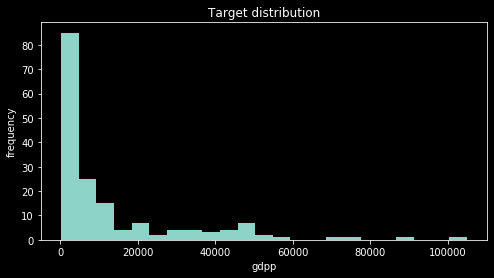

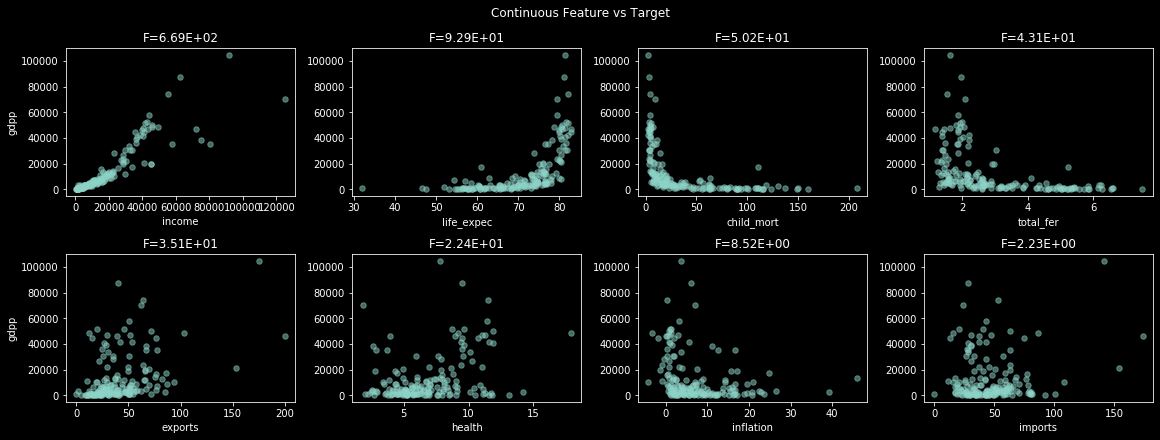

In [5]:
# Analyze the distribution of each feature to the GDP
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (8, 4)
dabl.plot(og_df, target_col='gdpp')

Correlation between "Income" and "GDP" seems to be strongly positive. Also, "Exports", "Imports" and "Life Expectancy" show a positive correlation.

In [6]:
# Remove the country column:
df = og_df.drop(columns='country')

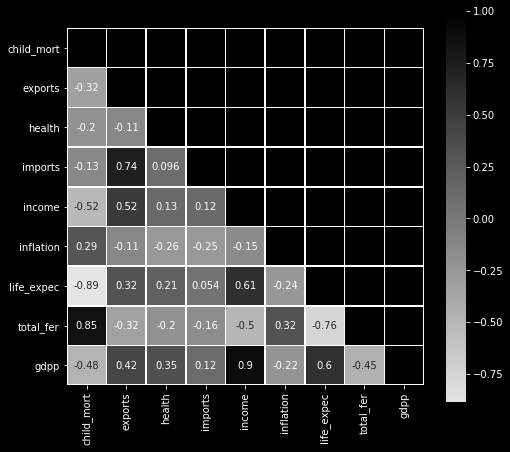

In [7]:
# Create a heatmap to further explore the correlation between the different features:
corr = df.corr()
fig, ax = plt.subplots(figsize=(8,8))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.light_palette('black', as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmax=None, center=0, square=True, annot=True, linewidths=0.5, cbar_kws={'shrink':0.9})
fig.savefig("heatmap.png")
plt.show()

Based on the heatmap plot we can observe the following:

    - Imports have a strong correlation with exports (+0.74)
    - Income and GDP have the strongest corrleation (+0.9)
    - Child mortality and life expectancy also show very strong correlation (+0.85)

3. The third step is now to begin preparing the data for the clustering models, and perform these models to the data.

In [8]:
# Scale the data:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [9]:
# Perform a PCA on the scaled data
pca = PCA(random_state=42)
pca.fit(scaled_data)
print('Number of components: ', pca.n_components_)

Number of components:  9


In [10]:
# Explore the amount of variance that each component explains:
variance = pca.explained_variance_ratio_
print('Amount of variance explained for each component:', variance)

Amount of variance explained for each component: [0.4595174  0.17181626 0.13004259 0.11053162 0.07340211 0.02484235
 0.0126043  0.00981282 0.00743056]


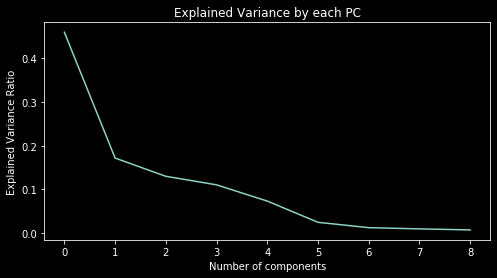

In [11]:
# Plot the explained variance:
plt.plot(variance)
plt.title('Explained Variance by each PC')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio')
plt.show()

The variance explained by the first two components are 46% and 17% respectively. 

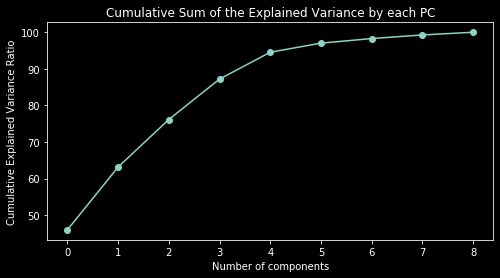

In [12]:
# Plot the cumulative variance by each PC:
cum_var = np.cumsum(np.round(variance, decimals=4)*100)
plt.plot(cum_var, "-o")
plt.title('Cumulative Sum of the Explained Variance by each PC')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

We can observe that with 4 components we can explain around 90% of the total variance. For visualization purposes we are going to use only the first and second component.

In [13]:
# Create a dataframe with each PC:
colnames = list(df.columns)
pca_df = pd.DataFrame({'Features':colnames, 'PC1':pca.components_[0], 'PC2':pca.components_[1], 'PC3':pca.components_[2],
                       'PC4':pca.components_[3], 'PC5':pca.components_[4], 'PC4':pca.components_[5], 'PC7':pca.components_[6],
                       'PC8':pca.components_[7], 'PC9':pca.components_[8]})
pca_df

Features       PC1       PC2       PC3       PC4       PC5       PC7  \
0  child_mort -0.419519  0.192884 -0.029544  0.200628 -0.168970 -0.079489   
1     exports  0.283897  0.613163  0.144761 -0.059333  0.057616 -0.707303   
2      health  0.150838 -0.243087 -0.596632  0.007276  0.518000 -0.249831   
3     imports  0.161482  0.671821 -0.299927 -0.030032  0.255376  0.592190   
4      income  0.398441  0.022536  0.301548  0.160347 -0.247150  0.095562   
5   inflation -0.193173 -0.008404  0.642520  0.066285  0.714869  0.104633   
6  life_expec  0.425839 -0.222707  0.113919 -0.601127  0.108220  0.018486   
7   total_fer -0.403729  0.155233  0.019549 -0.750689 -0.135262  0.028826   
8        gdpp  0.392645 -0.046022  0.122977  0.016779 -0.180167  0.242998   

        PC8       PC9  
0 -0.682743  0.327542  
1 -0.014197 -0.123082  
2  0.072497  0.113088  
3 -0.028946  0.099037  
4  0.352624  0.612982  
5 -0.011538 -0.025236  
6 -0.504664  0.294040  
7  0.293353 -0.026336  
8 -0.249696 -0.625646

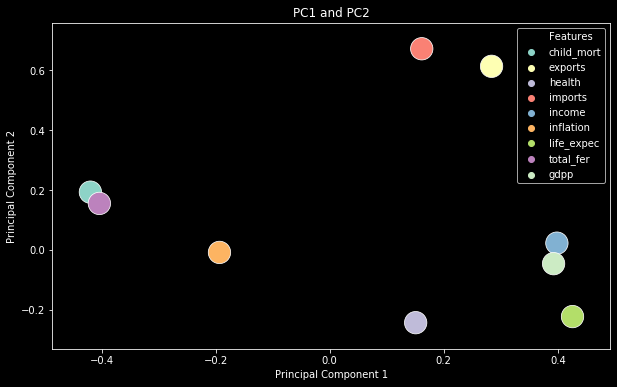

In [14]:
# Visualize the first two components:
fig = plt.figure(figsize=(10,6))
sns.scatterplot(pca_df['PC1'], pca_df['PC2'], hue=pca_df['Features'], marker='o', s=500)
plt.title('PC1 and PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can observe that the first principal component (PC1) is more related to GDP, Income and Life Expectancy features.

The second component is more related to Imports and Exports features.

4. The fourth step is start to deploy different clustering models on the scaled dataframe.

## K-Means:

In [15]:
# Fitting the model to k=3:
km = KMeans(n_clusters=3, random_state=42)
km.fit(scaled_data)
pd.DataFrame(km.cluster_centers_, columns=df.columns)

child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.360218 -0.437533 -0.155984 -0.189204 -0.686894   0.402111   -1.282180   
1   -0.406453 -0.031653 -0.224471  0.024162 -0.251770  -0.017167    0.254734   
2   -0.827449  0.645080  0.727411  0.190639  1.484243  -0.484921    1.079579   

   total_fer      gdpp  
0   1.364944 -0.604242  
1  -0.424343 -0.354481  
2  -0.791877  1.615995

In [16]:
# Count the records in each cluster:
pd.Series(km.labels_).value_counts()

1    84
0    47
2    36
dtype: int64

In [17]:
# Unscale the centers for better interpretation:
centroids = scaler.inverse_transform(km.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=df.columns)
centroids_df.style.background_gradient()

From the table above we can observe the following points about the clusters:

- In the cluster 0: Child Mortality, Inflation and Total Fertility are the major characteristics
- In the cluster 1: Exports, Imports and Life Expectancy are more characteristic than the cluster 0
- In the cluster 2: Income, GDP, Health and Life Expectancy are the major characteristics

In [18]:
# Label each row in the dataset with the corresponding cluster:
cluster_labels = km.fit_predict(scaled_data)
preds = km.labels_
df['Labels'] = preds
df.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  Labels  
0       5.82    553       0  
1       1.65   4090       1  
2       2.89   4460       1  
3       6.16   3530       0  
4       2.13  12200       1

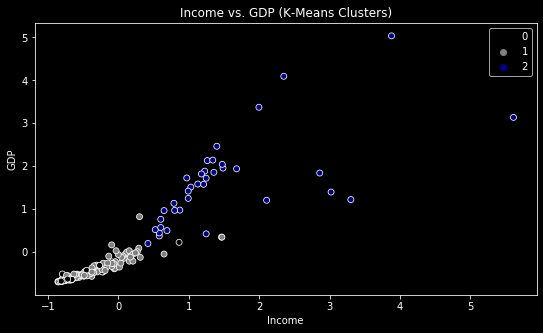

In [19]:
# Visualize different clusters on the most important features:
# Plot for Income vs. GDP:
fig1 = plt.figure(figsize=(9,5))
sns.scatterplot(scaled_data[:,4], scaled_data[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue'])
plt.title('Income vs. GDP (K-Means Clusters)')
plt.xlabel('Income')
plt.ylabel('GDP')
fig1.savefig("graph1.png")
plt.show()

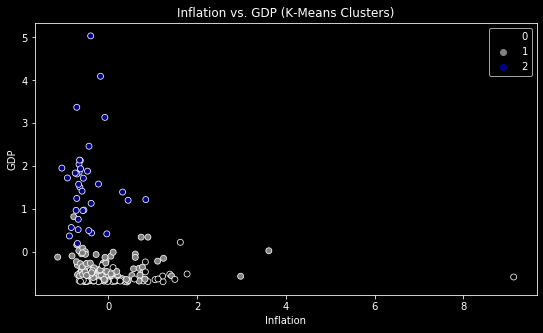

In [20]:
# Plot for Inflation vs. GDP
fig2 = plt.figure(figsize=(9,5))
sns.scatterplot(scaled_data[:,5], scaled_data[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue'])
plt.title('Inflation vs. GDP (K-Means Clusters)')
plt.xlabel('Inflation')
plt.ylabel('GDP')
fig2.savefig("graph2.png")
plt.show()

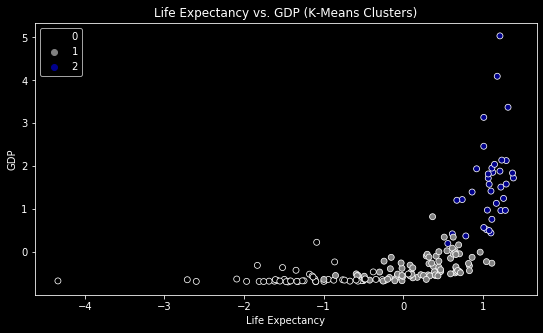

In [21]:
# Plot for Life Expectancy vs. GDP
fig3 = plt.figure(figsize=(9,5))
sns.scatterplot(scaled_data[:,6], scaled_data[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue'])
plt.title('Life Expectancy vs. GDP (K-Means Clusters)')
plt.xlabel('Life Expectancy')
plt.ylabel('GDP')
fig3.savefig("graph3.png")
plt.show()

## DBSCAN Clustering:

In [22]:
# Create a new dataset with the original columns and scale it:
db_data = df[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]
db_data_scaled = scaler.fit_transform(db_data)

In [23]:
# Perform the model:
clst = DBSCAN(eps=1, metric='euclidean')
clst.fit(db_data_scaled)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [24]:
# Assign the labels to the dataframe:
db_data['Labels'] = clst.labels_
print(db_data['Labels'].value_counts())
#db_data = db_data[db_data['Labels'] != -1]
#db_data['Labels'].value_counts()

-1    94
 0    52
 1    16
 2     5
Name: Labels, dtype: int64


In [25]:
# Interpret the clusters:
clst_df = db_data[db_data['Labels'] != -1]
clst_avgs = clst_df.groupby('Labels').mean()
clst_avgs.style.background_gradient()

In [26]:
# Label each row in the dataset with the corresponding cluster:
cluster_labels = clst.fit_predict(db_data_scaled)
preds = clst.labels_
db_data['Labels'] = preds
db_data.head()

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  Labels  
0       5.82    553       2  
1       1.65   4090       0  
2       2.89   4460      -1  
3       6.16   3530      -1  
4       2.13  12200       0

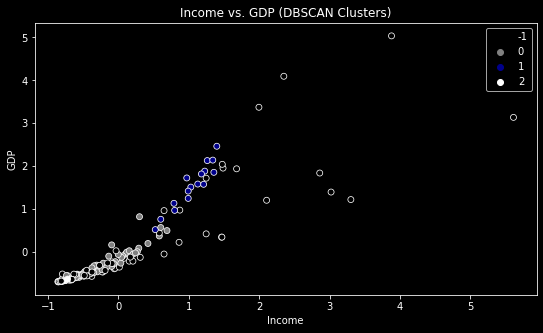

In [27]:
# Visualize different clusters on the most important features:
# Plot for Income vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(db_data_scaled[:,4], db_data_scaled[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue', 'white'])
plt.title('Income vs. GDP (DBSCAN Clusters)')
plt.xlabel('Income')
plt.ylabel('GDP')
plt.show()

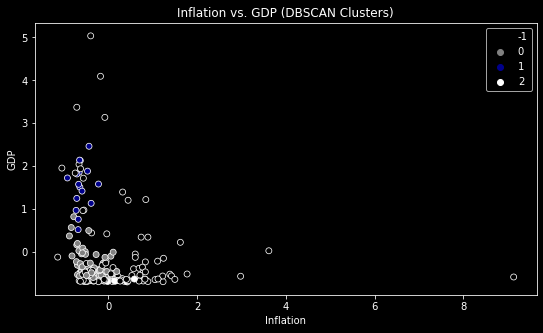

In [28]:
# Plot for Inflation vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(db_data_scaled[:,5], db_data_scaled[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue', 'white'])
plt.title('Inflation vs. GDP (DBSCAN Clusters)')
plt.xlabel('Inflation')
plt.ylabel('GDP')
plt.show()

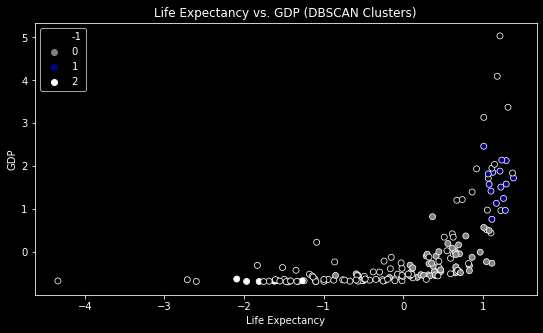

In [29]:
# Plot for Life Expectancy vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(db_data_scaled[:,6], db_data_scaled[:,8], hue=cluster_labels, palette=['black', 'gray', 'darkblue', 'white'])
plt.title('Life Expectancy vs. GDP (DBSCAN Clusters)')
plt.xlabel('Life Expectancy')
plt.ylabel('GDP')
plt.show()

## Hierarchical Clustering:

In [30]:
#Create an Agglomerative model on the scaled data:
hier_data = df[['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']]
hier_data_scaled = scaler.fit_transform(hier_data)
aggl = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hier = aggl.fit_predict(hier_data_scaled)

In [31]:
# Assign the clusters labels to a column in a dataframe with the original columns:
hierpreds = aggl.labels_
hier_data['Hier Clusters'] = hierpreds
hier_data['Hier Clusters'].value_counts()

1    106
0     34
2     27
Name: Hier Clusters, dtype: int64

In [32]:
# Interpret the clusters:
clst_avgs = hier_data.groupby('Hier Clusters').mean()
clst_avgs.style.background_gradient()

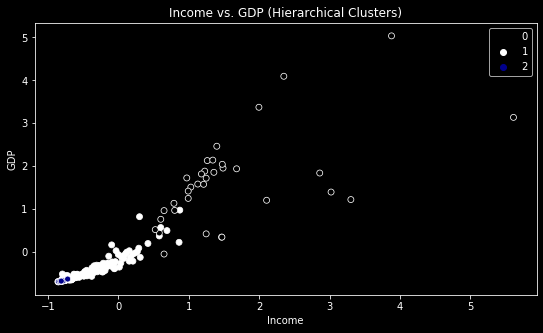

In [33]:
# Plot for Income vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(hier_data_scaled[:,4], hier_data_scaled[:,8], hue=hier, palette=['black', 'white', 'darkblue'])
plt.title('Income vs. GDP (Hierarchical Clusters)')
plt.xlabel('Income')
plt.ylabel('GDP')
plt.show()

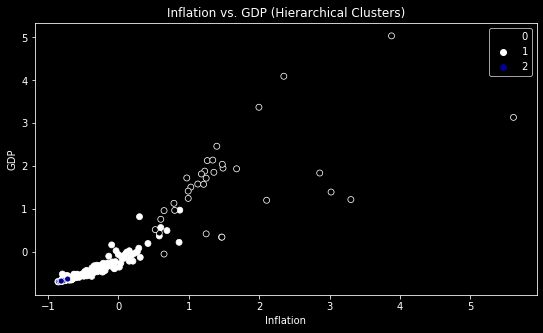

In [34]:
# Plot for Inflation vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(hier_data_scaled[:,4], hier_data_scaled[:,8], hue=hier, palette=['black', 'white', 'darkblue'])
plt.title('Inflation vs. GDP (Hierarchical Clusters)')
plt.xlabel('Inflation')
plt.ylabel('GDP')
plt.show()

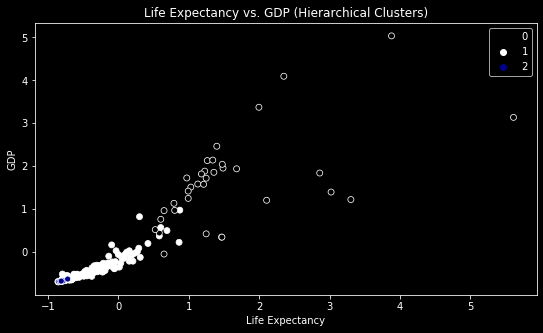

In [35]:
# Plot for Life Expectancy vs. GDP:
plt.figure(figsize=(9,5))
sns.scatterplot(hier_data_scaled[:,4], hier_data_scaled[:,8], hue=hier, palette=['black', 'white', 'darkblue'])
plt.title('Life Expectancy vs. GDP (Hierarchical Clusters)')
plt.xlabel('Life Expectancy')
plt.ylabel('GDP')
plt.show()

4. The fourth step is to analyze results and conclusions

In [36]:
# Add the country name column back to the dataframe:
og_df["Labels"] = km.labels_
og_df['Labels'] = og_df['Labels'].astype(str)
og_df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp Labels  
0       9.44        56.2       5.82    553      0  
1       4.49        76.3       1.65   4090      1  
2      16.10        76.5       2.89   4460      1  
3      22.40        60.1       6.16   3530      0  
4       1.44        76.8       2.13  12200      1

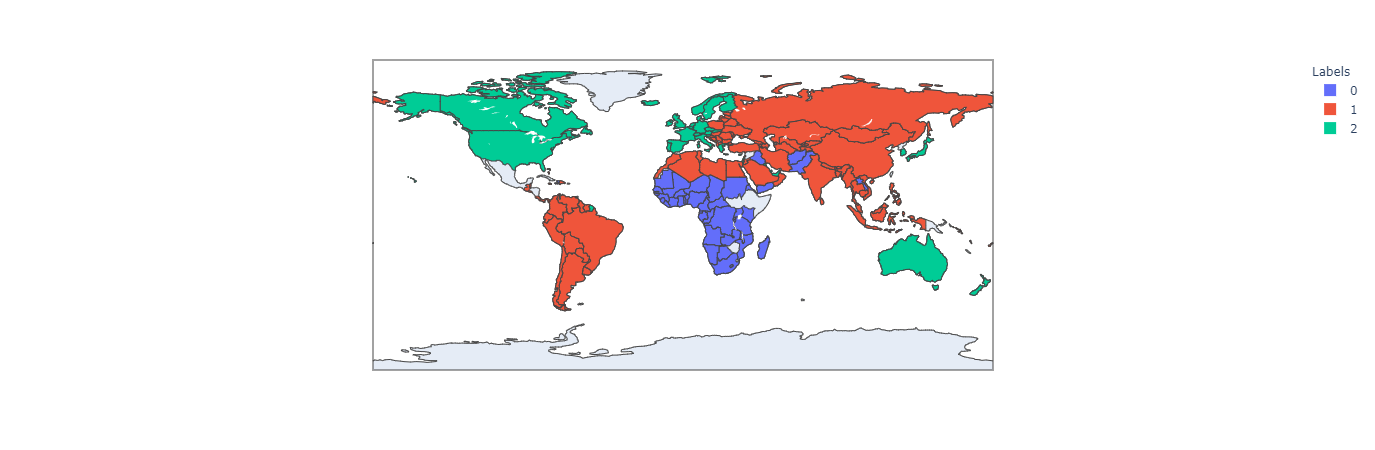

In [37]:
import plotly.express as px
px.choropleth(og_df, locations='country', color='Labels', locationmode='country names')

## Conclussions and recomendations

* Most countries located in central Africa are in dire need of help. They have the lowest health expenditure and the highest child mortality.

* Other countries located in the Middle East region, such as Pakistan, Iraq, Afghanistan, also show high levels of child mortality as well as high levels of inflation and low levels of economic growth.

* Our recommendation is to focus the organization resources specifically on those regions, and with special focus on improving the health system of those countries.